<a href="https://colab.research.google.com/github/kiharalab/DAQ/blob/main/DAQ_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DAQ-Score: A Deep-learning-based residue-wise Quality Assessment score for cryo-EM models
<a href="https://github.com/marktext/marktext/releases/latest">
   <img src="https://img.shields.io/badge/DAQ-v1.0.0-green">
   <img src="https://img.shields.io/badge/platform-Linux%20%7C%20Mac%20-green">
   <img src="https://img.shields.io/badge/Language-python3-green">
   <img src="https://img.shields.io/badge/Language-C-green">
   <img src="https://img.shields.io/badge/dependencies-tested-green">
   <img src="https://img.shields.io/badge/licence-GNU-green">
</a>      

DAQ is a computational tool using deep learning that can estimate the residue-wise local quality for protein models from cryo-Electron Microscopy (EM) maps.  

[Terashi, G., Wang, X., Maddhuri Venkata Subramaniya, S.R. et al. Residue-wise local quality estimation for protein models from cryo-EM maps. Nat Methods (2022). https://doi.org/10.1038/s41592-022-01574-4](https://www.nature.com/articles/s41592-022-01574-4)

Copyright (C) 2021 Genki Terashi* , Xiao Wang*, Sai Raghavendra Maddhuri Venkata Subramaniya, John J. G. Tesmer, and Daisuke Kihara, and Purdue University. 

License: GPL v3 for academic use. (For commercial use, please contact us for different licensing.)

Contact: Daisuke Kihara (dkihara@purdue.edu)

**We strongly suggest to use Google Chrome for DAQ-Score Colab version. Other browsers such as Safari may raise errors when uploading or downloading files.**

For more details, see **<a href="#Instructions">Instructions</a>** of the notebook and checkout the **[DAQ GitHub](https://github.com/kiharalab/DAQ)**. If you use DAQ score, please cite it: **<a href="#Citation">Citation</a>**.

# Protocol of DAQ-score
![](https://user-images.githubusercontent.com/50850224/142276557-c79df306-5cf9-40f9-a0b8-f7ef08176a7a.jpeg)

#Overview of DAQ
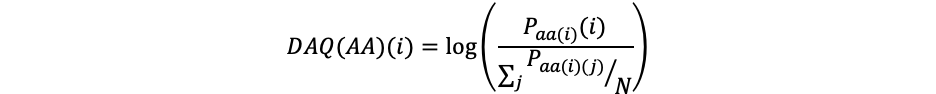

where aa(i) is the amino acid type of residue i, P_aa(i)(i) is the computed probability for amino acid type aa(i) for the nearest grid point to the Cα atom of residue i. As shown in the equation, the probability is normalized by the average probability of amino acid type aa(i) across over all atom positions in the protein model.

* If the assignment is correct, DAQ will be positive, and negative if the assignment may be incorrect.

* If a position in the map does not have distinct density pattern for the assigned amino acid (or secondary structure, Calpha atom), DAQ will be close to 0.

* If the entire model is fitted poorly? In that case, simply all the residues in the model will have a negative score, indicating that each residue in the model may be incorrectly assigned.

# Instructions <a name="Instructions"></a>

**Quick start**

Option 1:
**[Tutorial Slides](https://github.com/kiharalab/DAQ/blob/main/example/DAQ_tutorial.pptx)**

Option 2:
1. Connect to a gpu machine by clicking the right top button **"connect"** in the notebook, then we can run DAQ under GPU support.
2. Click the left running button in <a href="#Dependency">Install Dependencies</a> to install dependencies.
3. Upload your structure model in pdb format by clicking the left running button in <a href="#Structure">Upload Structure</a>. If you want to use our example, then choose the box **use_author_example**.
4. Upload your cryo-EM maps in mrc/map format by clicking the left running button in <a href="#Map">Upload Cryo EM maps</a>. If you want to use our example, please skip this step. Here we suggest user to upload a cryo-EM map with **spacing 1** to save the running time.<br>
Here is a simple instructions to do that via [ChimeraX](https://www.rbvi.ucsf.edu/chimerax/): <a name="ChimeraX"></a>
```
1 open your map via chimeraX. 
2 In the bottom command line to type command: vol resample #1 spacing 1.0
3 In ChimeraX, click "save", then choose "MRC density map(*.mrc)" in "Files of type", then in "Map" choose the resampled map, finally specify the file name and path to save.
4 Then you can use the resampled map to upload
```
5. Specify the Parameters in <a href="#Param">Parameters</a>. Either you modified or not, click the left running button to set it.
6. Running DAQ by by clicking the left running button in <a href="#Running">Run DAQ</a>. 
7. (Optional) Click the left running button in <a href="#Download">Download</a> to download the zip files. The score file will be saved in pdb format, you can visualize locally via Pymol:
<br>Open "daq_score_w9.pdb" in Pymol, then type command in Pymol's command line:
```
 spectrum b, red_white_blue,  all, -1,1
```
8. Visualize Local-Score online by clicking the left running button in <a href="#Visualization">Visualization</a>
9. Residue-wise Quality Plot by clicking the left running button in <a href="#Plot">Plot</a>. Here we will provide each chain's score plot separately. 

**Result in zip file**

1. An overall score PDB file, where scores of all residues are saved in b-factor column.
2. N-chain based score PDB file, where score of residues in the specific chain are saved in b-factor column.
3. Prediction File: prediction.txt, which includes all our predicted probabilities for all voxels scanned across the map.

# Run DAQ-Score Online



In [ ]:
#@title Install dependencies <a name="Dependency"></a>
#@markdown Please make sure the notebook is already connected to **GPU**, DAQ needs GPU support to run.<br>
#@markdown Click the right top button **"connect"**, then the notebook will automatically connect to a gpu machine
%cd /content
!pip install mrcfile==1.2.0 
!pip install numpy>=1.19.4
!pip install numba>=0.52.0
!pip install torch>=1.6.0
!pip install scipy>=1.6.0
!pip install py3Dmol
!pip install matplotlib
!rm -rf DAQ
!git clone https://github.com/kiharalab/DAQ --quiet
%cd DAQ 


/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/DAQ


In [ ]:
#@title Input protein structures <a name="Structure"></a>
#@markdown Please follow the instructions to upload your **pdb** file.

#@markdown If you have not prepared the example by yourself, you can use author's example to have a test. To do that, please select the following choice.
from google.colab import files
import os
import os.path
import re
import hashlib
import random
import string

rand_letters = string.ascii_lowercase
rand_letters = ''.join(random.choice(rand_letters) for i in range(20))
use_author_example = False #@param {type:"boolean"}
if use_author_example:
  pdb_input_path = os.path.join(os.getcwd(),"example")
  pdb_input_path = os.path.join(pdb_input_path,"3J6B_9.pdb")
  map_input_path = os.path.join(os.getcwd(),"example")
  map_input_path = os.path.join(map_input_path,"2566_3J6B_9.mrc")
else:
  root_dir = os.getcwd()
  upload_dir = os.path.join(root_dir,rand_letters)
  if not os.path.exists(upload_dir):
    os.mkdir(upload_dir)
  os.chdir(upload_dir)
  pdb_input = files.upload()

  for fn in pdb_input.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(pdb_input[fn])))
    pdb_input_path = os.path.abspath(fn)
    print("PDB save to %s"%pdb_input_path)
  os.chdir(root_dir)

Saving 7cn1.pdb to 7cn1.pdb
User uploaded file "7cn1.pdb" with length 747613 bytes
PDB save to /content/DAQ/cnsrirwgimtpjgiqbzux/7cn1.pdb


In [ ]:
#@title Input cryo-EM map <a name="Map"></a>
#@markdown If you choose to use author's example, please **skip** this. <br>
#@markdown Otherwise, please follow the instructions to upload your cryo-EM map file.   
#@markdown <br>
#@markdown **Please make sure the cryo-EM map is aligned with the uploaded structure.**
#@markdown <br>Here we suggest user to upload a cryo-EM map with **spacing 1** to save the running time. Detailed instructions with ChimeraX is <a href="#ChimeraX">ChimeraX resampling</a>
#@markdown <br> **Support file format: .mrc, .mrc.gz**
from google.colab import files
import os
import os.path
import re
import hashlib
import random
import string

rand_letters = string.ascii_lowercase
rand_letters = ''.join(random.choice(rand_letters) for i in range(20))
use_author_example = False #@param {type:"boolean"}
if not use_author_example:
  root_dir = os.getcwd()
  upload_dir = os.path.join(root_dir,rand_letters)
  if not os.path.exists(upload_dir):
    os.mkdir(upload_dir)
  os.chdir(upload_dir)
  map_input = files.upload()
  for fn in map_input.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(map_input[fn])))
    map_input_path = os.path.abspath(fn)
    print("Map save to %s"%map_input_path)
  os.chdir(root_dir)
else:
  print("you have chosen to use author's example, you can not upload map files any more.")

Saving emd_30413_zone.mrc to emd_30413_zone.mrc
User uploaded file "emd_30413_zone.mrc" with length 7927360 bytes
Map save to /content/DAQ/vxpimxgtfyzkculgtuwv/emd_30413_zone.mrc


In [ ]:

from google.colab import files
import os
import os.path
import re
import hashlib
#@markdown Specify other parameters(optional) <a name="Param"></a>
#contour = '0' #@param {type:"string"}
# ```author recommended contour level for the input map. Using contour level will not have any impact on the result, but can reduce the computation time. ```
# <br>```default:0. Suggested Range: [0,author_contour]```
half_window_size = '9' #@param {type:"string"}
#@markdown ```window size is used for smoothing the residue-wise score based on a sliding window scanning the entire sequence.```
#@markdown <br> ```Here whole_window_size=(half_window_size*2+1) ```<br>```default half_window_size: 9(integer). Suggested Range: [1,9]. ```
stride = '2'#@param {type:"string"}
#@markdown Detailed explanation can be seen: [stride_definition](https://deepai.org/machine-learning-glossary-and-terms/stride)<br>
#@markdown ```stride step for scanning the cryo-EM map. Increasing the stride can reduce the computation time but may lead to unreliable result. ```<br>``` default stride: 1(integer). Suggested range: [1,4].```
batch_size = '512'#default param

In [ ]:
#@title Run DAQ <a name="Running"></a>
#@markdown Please allow 5min-2hours to get the output, since 3D input processing and inferencing takes some time. 
#@markdown <br>Our running time is directly correlated to the size of the structures. For example, a map with 50 * 50 * 50 can take 3 minutes to finish when you set stride=1.
#@markdown <br>If your structure is too big, you can use stride=2 in last step.
!git pull origin main
!python main.py --mode=0 -F "{map_input_path}"  -P "{pdb_input_path}" --window $half_window_size --stride $stride --batch_size $batch_size

From https://github.com/kiharalab/DAQ
 * branch            main       -> FETCH_HEAD
Already up to date.
/content/DAQ/Predict_Result created
/content/DAQ/Predict_Result/emd_30413_zone created
Grid size of different axis is different, please specify --resize=1 in command line to call another slow process to deal with it!
Origin: (76.908005, 82.212, 124.644005)
Previous voxel size: (0.88400006, 0.884, 0.884)
nx, ny, nz 144 139 99
nxs,nys,nzs 0 0 0
mx,my,mz 144 139 99
Previouse size: (144, 139, 99)  Current map size: [127, 122, 87]
Resizing finished 0/127
Resizing finished 10/127
Resizing finished 20/127
Resizing finished 30/127
Resizing finished 40/127
Resizing finished 50/127
Resizing finished 60/127
Resizing finished 70/127
Resizing finished 80/127
Resizing finished 90/127
Resizing finished 100/127
Resizing finished 110/127
Resizing finished 120/127
nx              : 144
ny              : 139
nz              : 99
mode            : 2
nxstart         : 0
nystart         : 0
nzstart       

In [ ]:
#@title Download Estimation Output <a name="Download"></a>
#@markdown The pdb file with estimated score will be compressed and downloaded. You can visualize your structure score by Pymol.
from google.colab import files
import os, tarfile
import shutil
import zipfile
zip_format = True #@param {type:"boolean"} 
#@markdown If you want to download tar.gz format file, please not choose **zip_format** box.
download_path = os.path.join(os.getcwd(),"Predict_Result")
map_name = os.path.split(map_input_path)[1].replace(".mrc","")
map_name = map_name.replace(".gz","")
map_name = map_name.replace("(","").replace(")","")
user_download_path = os.path.join(download_path,map_name)
tmp_download_dir = os.path.join(os.getcwd(),"tmp")
if not os.path.exists(tmp_download_dir):
  os.mkdir(tmp_download_dir)
os.system("rm "+str(tmp_download_dir)+"/*")
for item in os.listdir(user_download_path):
  if ".pdb" in item or ".txt" in item:
    shutil.copy(os.path.join(user_download_path,item),os.path.join(tmp_download_dir,item))
if zip_format:
  tar_path = os.path.join(download_path,map_name+"_eval.zip")
else:
  tar_path = os.path.join(download_path,map_name+"_eval.tar.gz")
def zip_file(tar_path,src_dir):
    zip_name = tar_path
    z = zipfile.ZipFile(zip_name,'w',zipfile.ZIP_DEFLATED)
    for dirpath, dirnames, filenames in os.walk(src_dir):
        fpath = dirpath.replace(src_dir,'')
        fpath = fpath and fpath + os.sep or ''
        for filename in filenames:
            z.write(os.path.join(dirpath, filename),fpath+filename)
            print ('==Compress Success!==',filename)
    z.close()

def make_targz(output_filename, source_dir):
    """
    :param output_filename: 
    :param source_dir:
    :return: bool
    """
    try:
        with tarfile.open(output_filename, "w:gz") as tar:
            tar.add(source_dir, arcname=os.path.basename(source_dir))

        return True
    except Exception as e:
        print(e)
        return False
if zip_format:
  zip_file(tar_path,tmp_download_dir)
else:
  make_targz(tar_path,tmp_download_dir)
files.download(tar_path)

#@markdown <br>**Visualization command**<br>Open "daq_score_w9.pdb" file in Pymol, type following command in Pymol command line:
#@markdown ```
#@markdown  spectrum b, red_white_blue,  all, -1,1
#@markdown ```

==Compress Success!== prediction.txt
==Compress Success!== daq_score_w9.pdb
==Compress Success!== daq_score_w9_D.pdb
==Compress Success!== daq_score_w9_A.pdb
==Compress Success!== daq_score_w9_C.pdb
==Compress Success!== daq_raw_score.pdb
==Compress Success!== daq_score_w9_B.pdb


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

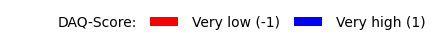

In [ ]:
#@title Structure Quality Visualization (3D) <a name="Visualization"></a>
#get the generated pdb path
import os
window_size = int(half_window_size)
download_path = os.path.join(os.getcwd(),"Predict_Result")
map_name = os.path.split(map_input_path)[1].replace(".mrc","")
map_name = map_name.replace(".gz","")
map_name = map_name.replace("(","").replace(")","")
output_pdb_path = os.path.join(download_path,map_name)
output_pdb_path2 = os.path.join(output_pdb_path,"daq_score_w"+str(int(window_size))+".pdb")
final_pdb_path = os.path.join(output_pdb_path,"daq_score_w"+str(int(window_size))+"_reverse.pdb")
#print(os.path.getsize(output_pdb_path))
def reverse_pdb(filename,new_file_name):
    
    with open(filename,"r") as rfile:
      with open(new_file_name,'w') as wfile:
        for l in rfile:
            #print(l)
            if(l.startswith('ATOM')):
                sco=float(l[61:67])
                line = l[:60]+"%6.2f"%(sco)+"\n"
                wfile.write(line)
reverse_pdb(output_pdb_path2,final_pdb_path)
import matplotlib.pyplot as plt
def plot_plddt_legend():
  thresh = ['DAQ-Score:','Very low (-1)','Very high (1)']
  plt.figure(figsize=(1,0.1),dpi=100)
  ########################################
  for c in ["#FFFFFF","#FF0000","#0000FF"]:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False,
             loc='center', ncol=6,
             handletextpad=1,
             columnspacing=1,
             markerscale=0.5,)
  plt.axis(False)
  return plt
#exit()
#Visualize
import py3Dmol
def show_pdb(output_pdb_path):
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(output_pdb_path,'r').read(),'pdb')
  view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient':'rwb','min':-1,'max':1}}})
  #view.setStyle({'cartoon': {'color':'spectrumb'}})
  #view.setStyle({'cartoon': {'spectrum': {'prop':'b','min':-1,'max':1}}})
  view.zoomTo()
  return view
show_pdb(final_pdb_path).show()
plot_plddt_legend().show() 

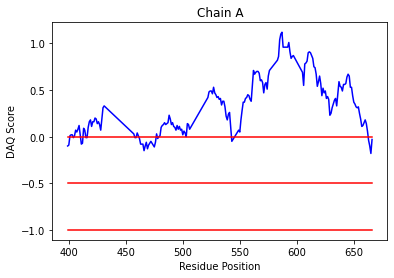

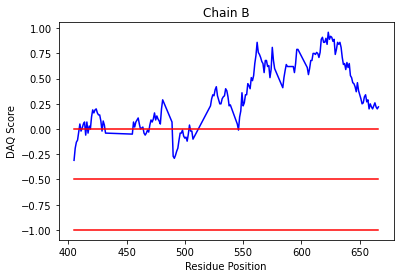

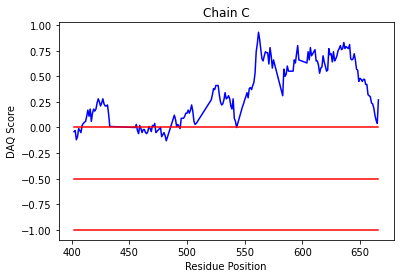

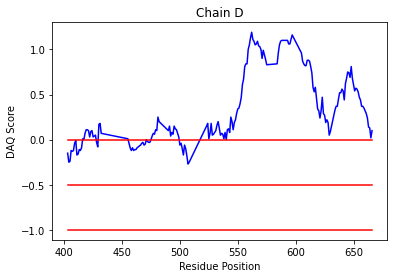

In [ ]:
#@title Residue-wise Quality Plot (2D) <a name="Plot"></a>
import numpy as np
window_size = int(half_window_size)
def get_score(filename):
    p={}
    with open(filename) as result:
        for l in result:
            #print(l)
            if(l.startswith('ATOM') and l[12:16].replace(" ","") == 'CA'):
                
                #print('|'+l[30:38]+'|'+l[38:46]+'|'+l[46:54]+'|',resn)
                l = l.strip("\n")
                split_result = l.split()
                resn=int(float(l[22:26]))
                p[resn]=float(split_result[-1])
    return p
import matplotlib.pyplot as plt
def plot_relationship(x_input,y_input,x_label,y_label,title=None):
  plt.clf()
  plt.plot(x_input,y_input,"b-")
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  y_line1 = np.ones(len(x_input))*0
  y_line2 = -np.ones(len(x_input))*0.5
  y_line3 = -np.ones(len(x_input))*1.0
  plt.plot(x_input,y_line1,"r-")
  plt.plot(x_input,y_line2,"r-")
  plt.plot(x_input,y_line3,"r-")
  if title is not None:
    plt.title(title)
  return plt

#print(os.path.getsize(output_pdb_path))
def reverse_pdb(filename,new_file_name):
    
    with open(filename,"r") as rfile:
      with open(new_file_name,'w') as wfile:
        for l in rfile:
            #print(l)
            if(l.startswith('ATOM')):
                sco=float(l[61:67])
                line = l[:60]+"%6.2f"%(sco)+"\n"
                wfile.write(line)
def read_chain_set(filename):
    #read each residues for all other informations
    chain_set = set()
    with open(filename) as result:
        for l in result:
            if l.startswith('ATOM'):
                chain_name = l[21]
                chain_set.add(chain_name)
    return chain_set
import os
download_path = os.path.join(os.getcwd(),"Predict_Result")
map_name = os.path.split(map_input_path)[1].replace(".mrc","")
map_name = map_name.replace(".gz","")
map_name = map_name.replace("(","").replace(")","")
output_pdb_path = os.path.join(download_path,map_name)
output_pdb_path2 = os.path.join(output_pdb_path,"daq_score_w"+str(int(window_size))+".pdb")
chain_list = read_chain_set(output_pdb_path2)
chain_list = list(chain_list)
chain_list.sort()
for chain_name in chain_list:
  output_pdb_path3 = os.path.join(output_pdb_path,"daq_score_w"+str(int(window_size))+"_"+str(chain_name)+".pdb")
  final_pdb_path3 = os.path.join(output_pdb_path,"daq_score_w"+str(int(window_size))+"_reverse.pdb")
  reverse_pdb(output_pdb_path3,final_pdb_path3)
  final_pdb_path3 = output_pdb_path3
  score_dict = get_score(final_pdb_path3)
  res_list = list(score_dict.keys())
  score_list = list(score_dict.values())
  plt_handler = plot_relationship(res_list,score_list,"Residue Position","DAQ Score","Chain "+str(chain_name))
  plt_handler.show()
#@markdown ***Residues with a DAQ-score of below these three cutoff values may not be correct, and thus worthwhile to check.***




## Citation: <a name="Citation"></a>

Genki Terashi* , Xiao Wang*, Sai Raghavendra Maddhuri Venkata Subramaniya, John J. G. Tesmer & Daisuke Kihara. Residue-Wise Local Quality Estimation for Protein Models from Cryo-EM Maps.  Nature Methods (2021). (Submitted)
```
@article{genki2022DAQ,   
  title={Residue-Wise Local Quality Estimation for Protein Models from Cryo-EM Maps},   
  author={Genki Terashi, Xiao Wang, Sai Raghavendra Maddhuri Venkata Subramaniya, John J. G. Tesmer, and Daisuke Kihara},    
  journal={Nature Methods},    
  year={2022}    
}   
```